In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from my_transformer import change_to_datetime, divide_datetime, add_dayofweek, feature_selection, one_hot_encoding, standard_scaler, concat, drop_feature

In [3]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

In [4]:
knn = KNeighborsRegressor(n_neighbors=5)
linear = LinearRegression()
sgd = SGDRegressor(max_iter=None, eta0=0.01, penalty='l2', random_state=30)
ridge = Ridge(alpha=1, random_state=30)
lasso = Lasso(alpha=1, random_state=30)
elastic = ElasticNet(alpha=1, l1_ratio=0.5, random_state=30)
dt = DecisionTreeRegressor(max_depth=None, random_state=30)
rf = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=30, n_jobs=-1)
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=30)
svm = SVR(C=1, kernel='rbf', gamma='auto_deprecated')

In [5]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)
    
    # 평균을 낸다.
    mean_difference = difference.mean()
    
    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)

In [6]:
preparation = joblib.load("preparation.pkl")
pipeline_cat = joblib.load("pipeline_cat.pkl")
pipeline_num = joblib.load("pipeline_num.pkl")

In [7]:
train = pd.read_csv('train.csv')
# train = pd.read_csv("data/train.csv", parse_dates=["datetime"]) 와 같이 불러오면 data type을 변경할 필요 없음
test = pd.read_csv('test.csv')

In [8]:
data = train.drop(['casual', 'registered', 'count'], axis=1)
y = train['count']

In [9]:
data = preparation.transform(data)
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,2011,1,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,2011,1,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,2011,1,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,2011,1,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,2011,1,1,4,5


In [10]:
feature_cat = ['holiday', 'workingday', 'weather', 'year', 'month', 'hour', 'dayofweek']
feature_num = ['temp', 'humidity', 'windspeed']

In [11]:
pipeline_cat = make_pipeline(
    feature_selection(feature_cat),
    one_hot_encoding('weather', 'weather'),
    one_hot_encoding('hour', 'hour'),
)
joblib.dump(pipeline_cat, "pipeline_cat.pkl")

['pipeline_cat.pkl']

In [12]:
X_cat = pipeline_cat.transform(data)
X_num = pipeline_num.transform(data)
X = concat(X_cat, X_num)

In [13]:
remove = ['dayofweek', 'weather_4', 'month', 'windspeed']
drop = drop_feature(remove)
X = drop.transform(X)

In [14]:
data_test = preparation.transform(test)
X_test_cat = pipeline_cat.transform(data_test)
X_test_num = pipeline_num.transform(data_test)
X_test = concat(X_test_cat, X_test_num)
X_test = drop.transform(X_test)

In [15]:
rf= RandomForestRegressor(max_depth=32, n_estimators=900, random_state=30)
score = cross_val_score(rf, X, y, cv=5, scoring=rmsle_scorer).mean()

In [16]:
score

0.6412042941839385

In [17]:
rf.fit(X, y)
prediction = rf.predict(X_test)

[Text(0.5, 0, 'count'), Text(0.5, 1.0, 'test')]

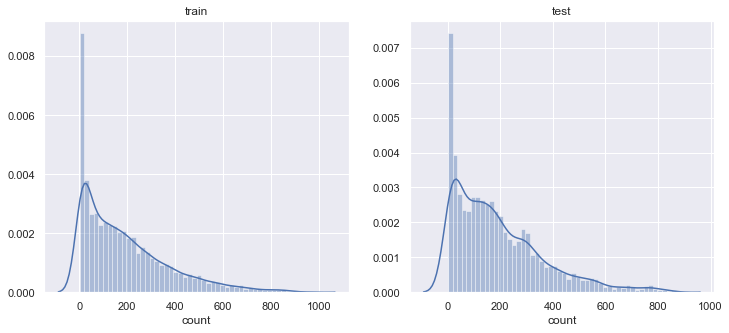

In [22]:
fig, (ax1, ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y, ax=ax1, bins=50)
ax1.set(title="train", xlabel='count')
sns.distplot(prediction, ax=ax2, bins=50)
ax2.set(title="test", xlabel='count')

## # Submission

In [18]:
submission = pd.read_csv("sampleSubmission.csv")
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [19]:
submission["count"] = prediction
submission.head()

,datetime,count
0,2011-01-20 00:00:00,20.664338
1,2011-01-20 01:00:00,6.775490
2,2011-01-20 02:00:00,5.080630
3,2011-01-20 03:00:00,7.700361
4,2011-01-20 04:00:00,5.512203


In [20]:
submission.to_csv("score_{:.3f}_submission.csv".format(score), index=False)

### 최종 score : 0.54